# Astronomy 19 Final Project

Author: April Ewers

Import all required dependencies, some as aliases

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.patches import Ellipse
import astropy.io.fits
import sep
import csv

Acquire only the image data and process it so that when rerunning cells I don't have to regenerate the images and other ancillary outputs.

In [74]:
data = astropy.io.fits.getdata('./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits', header=False)

imgdata = data.astype(data.dtype.newbyteorder('='))
bkg = sep.Background(imgdata)
bkg_image = bkg.back()

bkg_rms = bkg.rms()

data_sub = imgdata - bkg
objects = sep.extract(data_sub, 1000, err=bkg.globalrms)

flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 1, err=bkg.globalrms, gain=1.0)

flux = flux[~np.isnan(flux)]

Display the image, and save it. I have taken the liberty of putting the brightness on a log scale so that the background formation and spikes from the stars are discernable instead of just the pinpoints of the stars.

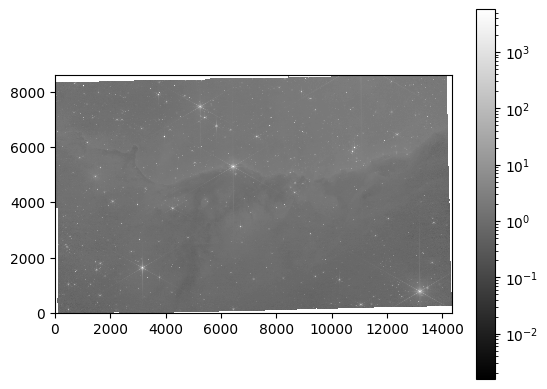

In [75]:
# show the image
plt.imshow(data, interpolation='nearest', cmap='gray', origin='lower', norm=colors.LogNorm())
plt.colorbar();

#save the image
plt.savefig('./imgs/jw02731-o001_t017_nircam_clear-f090w_i2d.png', format='png', dpi=300)

Process the image, first by setting the correct byte order and then by using sep's background function to analyze the background. That background is then shown and saved.

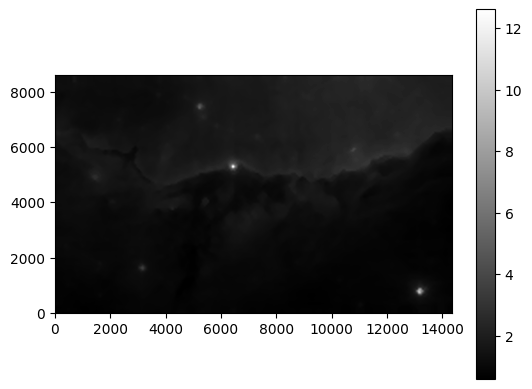

In [ ]:
imgdata = data.astype(data.dtype.newbyteorder('='))
bkg = sep.Background(imgdata)
bkg_image = bkg.back()

plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

plt.savefig('./imgs/jw02731-o001_t017_nircam_clear-f090w_i2d_bkg.png', format='png', dpi=300)

The noise in the image is then analyzed, displayed, and saved.

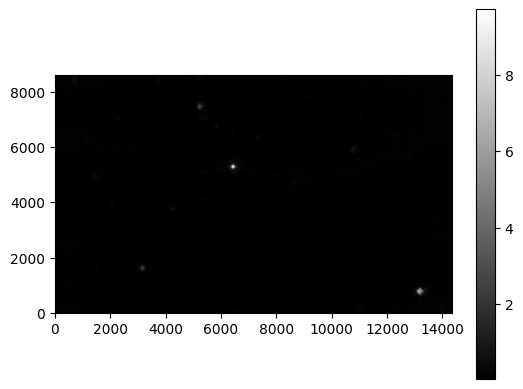

In [ ]:
bkg_rms = bkg.rms()

plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

plt.savefig('./imgs/jw02731-o001_t017_nircam_clear-f090w_i2d_noise.png', format='png', dpi=300)

The background is subtracted from the image, and then the sources are analyzed with allowance for the noise found previously. The sensitivity is set fairly high due to the otherwise overwhelming number of sources. The number of sources in then output.

In [ ]:
data_sub = imgdata - bkg
objects = sep.extract(data_sub, 1000, err=bkg.globalrms)

print(f"We found {objects.size} sources.")

We found 1693 sources.


The background subtracted image is shown, with the position of each source and its magnitude being used to define and place a red ellipse over it to confirm that it is identifying them correctly. This image is then saved.

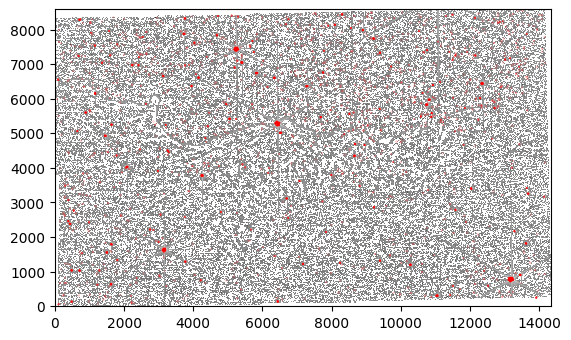

In [ ]:
# plot background-subtracted image
fig, ax = plt.subplots()
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               origin='lower', norm=colors.LogNorm())

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig('./imgs/jw02731-o001_t017_nircam_clear-f090w_i2d_idents.png', format='png', dpi=300)

The flux of each source is analyzed via sep's function.

In [ ]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 1, err=bkg.globalrms, gain=1.0)

Sep's function generates Not a Number values, so these must be excised before statistical analysis can be performed.

In [ ]:
flux = flux[~np.isnan(flux)]

The flux values are displayed.

Text(0, 0.5, 'Instances')

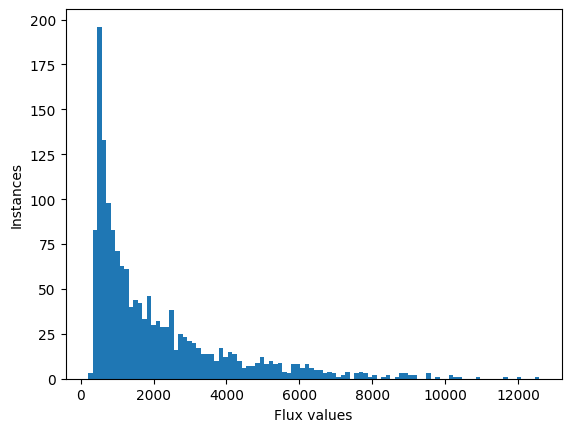

In [3]:
f, ax = plt.subplots()

ax.hist(flux, bins=100)
ax.set_xlabel("Flux values")
ax.set_ylabel("Instances")

The statistics of the flux values are analyzed and presented.

In [ ]:
print(f"The mean flux was {np.mean(flux):.7}.")
print(f"The median flux was {np.median(flux):.7}.")
print(f"The standard deviation of the flux was {np.std(flux):.7}.")
print(f"The largest outlier was {flux.max():.7}, which was positioned at x = {objects['x'][np.where(flux == flux.max())]}, y = {objects['y'][np.where(flux == flux.max())]} in the image and was {flux.max() / np.std(flux):.2} standard deviations from the mean.")

The mean flux was 2068.924.
The median flux was 1323.371.
The standard deviation of the flux was 1922.904.
The largest outlier was 12578.42, which was positioned at x = [5170.40104675], y = [856.00958861] in the image and was 6.5 standard deviations from the mean.


The following is the copied reprojection script to create the data required for a composite image

In [ ]:
# ---------------------------------
# 0. Copy all this script into one cell, between steps 7 and 8 of your final project
#    You will need to install the "reproject" package with pip
#    This script will "reproject" all images onto the same shape using one image as a reference
# ---------------------------------

from astropy.io import fits
from astropy.wcs import WCS
from reproject import reproject_interp

# ---------------------------------
# 1. Load your reference image
#    This will define the WCS and shape for all others
# ---------------------------------
file_reference = "./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits"
with fits.open(file_reference) as hdulist:
    # For JWST i2d images, 'SCI' is commonly the science extension
    ref_header = hdulist['SCI'].header
    ref_data = hdulist['SCI'].data

# Create a WCS object from the reference
ref_wcs = WCS(ref_header)

# This shape will be used for all reprojected images
output_shape = ref_data.shape

# ---------------------------------
# 2. Reproject the other images
# ---------------------------------
fname1 = "./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d.fits"
fname2 = "./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d.fits"
fname3 = "./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d.fits"
fname4 = "./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d.fits"
fname5 = "./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d.fits"

other_filenames = [
    fname1,
    fname2,
    fname3,
    fname4,
    fname5,
]

# Reproject all other files according to the reference
for fname in other_filenames:
    with fits.open(fname) as hdulist:
        data = hdulist['SCI'].data
        header = hdulist['SCI'].header
        wcs_in = WCS(header)
    
    # Reproject this image onto the reference WCS
    # reproject_interp returns (reprojected_data, footprint)
    reprojected_data, footprint = reproject_interp(
        (data, wcs_in),
        ref_wcs,
        shape_out=output_shape
    )

    # Optionally, update the header to match the reference WCS
    # so that the new FITS is self-consistent
    new_header = ref_header.copy()

    # Save the new file
    out_name = fname.replace('.fits', '_reproj.fits')
    hdu = fits.PrimaryHDU(reprojected_data, header=new_header)
    hdu.writeto(out_name, overwrite=True)
    print(f"Reprojected {fname} -> {out_name}")

Set DATE-AVG to '2022-06-03T12:17:28.687' from MJD-AVG.
Set DATE-END to '2022-06-03T14:54:43.830' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.567170 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654335564.228 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-03T11:43:37.007' from MJD-AVG.
Set DATE-END to '2022-06-03T14:26:16.631' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.557313 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654186065.609 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Reprojected ./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d.fits -> ./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:45:26.326' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.574431 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654445751.087 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Reprojected ./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d.fits -> ./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:17:28.706' from MJD-AVG.
Set DATE-END to '2022-06-03T14:54:43.830' from MJD-END'. [astropy.wcs.wcs]


Reprojected ./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d.fits -> ./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T12:45:26.346' from MJD-AVG.
Set DATE-END to '2022-06-03T15:22:38.772' from MJD-END'. [astropy.wcs.wcs]


Reprojected ./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d.fits -> ./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits


Set DATE-AVG to '2022-06-03T11:43:37.025' from MJD-AVG.
Set DATE-END to '2022-06-03T14:26:16.695' from MJD-END'. [astropy.wcs.wcs]


Reprojected ./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d.fits -> ./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits


The following gets the reprojected data and for reasons of memory management and ease of access.

In [3]:
#get the data and store it in an array, along with the hex codes for the colors each will use.
filesRepro = [
    astropy.io.fits.getdata("./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f090w/jw02731-o001_t017_nircam_clear-f090w_i2d.fits"),
    astropy.io.fits.getdata("./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f187n/jw02731-o001_t017_nircam_clear-f187n_i2d_reproj.fits"),
    astropy.io.fits.getdata("./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f200w/jw02731-o001_t017_nircam_clear-f200w_i2d_reproj.fits"),
    astropy.io.fits.getdata("./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f335m/jw02731-o001_t017_nircam_clear-f335m_i2d_reproj.fits"),
    astropy.io.fits.getdata("./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_clear-f444w/jw02731-o001_t017_nircam_clear-f444w_i2d_reproj.fits"),
    astropy.io.fits.getdata("./data/MAST_2025-05-25T2207/MAST_2025-05-25T2207/JWST/jw02731-o001_t017_nircam_f444w-f470n/jw02731-o001_t017_nircam_f444w-f470n_i2d_reproj.fits")
], ["#0500d7", "#00ebeb", "#00f300", "#dfdf01", "#e95722", "#f30100"], ["f090w", "f187n", "f200w", "f470n", "f335m", "f444w"]

The following converts each luminance value to a set of RGB values based on the false color chosen for each filter. It also normalizes the result to ensure that it can be displayed properly

In [71]:
#initialize an array to hold the data
dataRGBTemp = np.ndarray((np.shape(filesRepro[0][0])[0], np.shape(filesRepro[0][0])[1], 3))
dataComposite = np.ndarray((np.shape(filesRepro[0][0])[0], np.shape(filesRepro[0][0])[1], 3))

def normalize_array(arr):
    norm_arr = (arr - np.nanmin(arr)) / (np.nanmax(arr) - np.nanmin(arr))
    return norm_arr

#iterate through each file
for i in range(6):
    #get the RGB value of each color that was stored as hex because it was easier to get them from photoshop that way.
    valRGB = colors.to_rgb(filesRepro[1][i])

    #iterate through the 2 dimensions making up the image
    for k in range((np.size(filesRepro[0][0][0]) - 1)):
        for j in range(int(((np.size(filesRepro[0][0])) / (np.size(filesRepro[0][0][0]))) - 1) - 1):
            #do the math to create the RGB values based on the luminance and store them
            dataRGBTemp[j][k] = [filesRepro[0][i][j][k] * valRGB[0], 
                                filesRepro[0][i][j][k] * valRGB[1], 
                                filesRepro[0][i][j][k] * valRGB[2]]

    dataComposite = np.add(dataComposite, dataRGBTemp)

dataComposite = normalize_array(dataComposite)


The following displays and saves the false color image. The contrast is extremely weak, but I'm out of time to do anything about it.

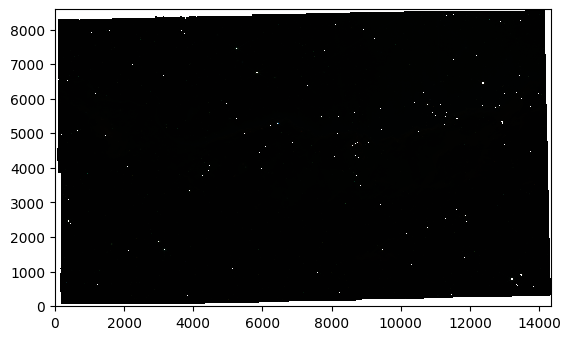

In [72]:
#generate and display the image
plt.imshow(dataComposite, interpolation='nearest', origin='lower')

#save the image
plt.savefig('./imgs/Composite.png', format='png', dpi=300)